In [1]:
import os
os.chdir("..")
assert 'PromptDataExtract' in os.getcwd()

In [2]:
# Load settings
from backend import sett, postgres
sett.load_settings()
postgres.load_settings()

Load OK: settings.yaml


In [3]:
# Connect to database
db = postgres.connect('polylet')

      -- postgres_ SSH tunnel established.
NOTE  -- postgres_ Connected to PostGres DB: polylet (took 0.041 s)


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
try:
    plt.style.use("~/matplotlib.mplstyle")
except: pass

In [5]:
def execute(sql, **kwargs) -> pd.DataFrame:
    """ Query the database using raw sql.
        Return a pandas dataframe containing the results.
    """
    results = postgres.raw_sql(sql, kwargs)
    if not results:
        return None
    return pd.DataFrame.from_records(results, columns=results[0]._fields)

### Parsing

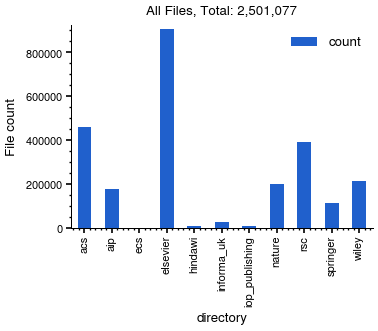

,directory,count
0,acs,457468
1,aip,177932
2,ecs,42
3,elsevier,907234
4,hindawi,6951
5,informa_uk,27900
6,iop_publishing,8007
7,nature,198487
8,rsc,392347
9,springer,111360


In [6]:
df = execute("""
             SELECT directory, count(*) FROM paper_corpus pc
             GROUP BY directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='File count', title=f"All Files, Total: {total:,}")
plt.savefig('notebooks/files_per_directory.png', dpi=600)
plt.show()
df

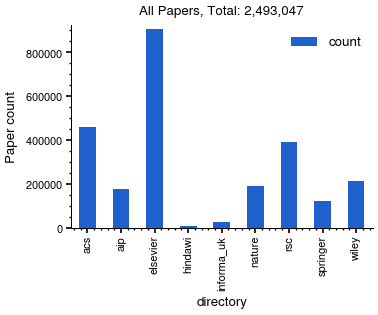

,directory,count
0,acs,457510
1,aip,177932
2,elsevier,907234
3,hindawi,6951
4,informa_uk,27898
5,nature,189039
6,rsc,392346
7,springer,120808
8,wiley,213329


In [8]:
df = execute("""
             SELECT directory, count(*) FROM papers p
             GROUP BY directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Paper count', title=f"All Papers, Total: {total:,}")
plt.savefig('notebooks/papers_per_directory.png', dpi=600)
plt.show()
df

In [7]:
print("Papers in database, not in corpus:")
execute("""
    SELECT count(*) FROM papers p
    WHERE NOT EXISTS (
        SELECT 1 FROM paper_corpus pc 
        WHERE pc.doi = p.doi
    );
""")

Papers in database, not in corpus:


,count
0,89386


In [8]:
print("Papers in corpus, not in database:")
execute("""
    SELECT count(*) FROM paper_corpus pc 
    WHERE NOT EXISTS (
        SELECT 1 FROM papers p 
        WHERE p.doi = pc.doi
    );
""")

Papers in corpus, not in database:


,count
0,97416


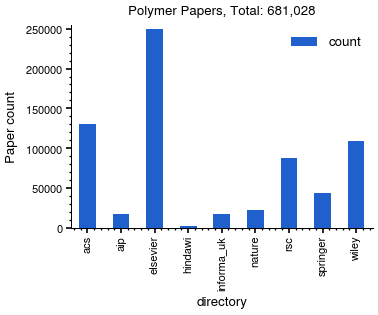

,directory,count
0,acs,130971
1,aip,17070
2,elsevier,250057
3,hindawi,2605
4,informa_uk,17396
5,nature,22208
6,rsc,87429
7,springer,44324
8,wiley,108968


In [9]:
df = execute("""
             SELECT directory, count(*) FROM papers p
             JOIN filtered_papers fp on fp.doi = p.doi
             GROUP BY directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Paper count', title=f"Polymer Papers, Total: {total:,}")
plt.savefig('notebooks/polymer_papers_per_directory.png', dpi=600)
plt.show()
df

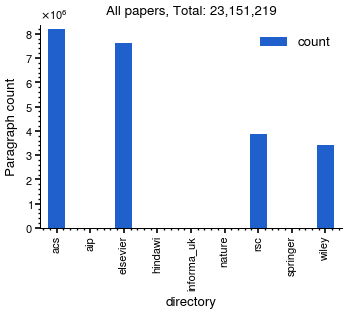

,directory,count
0,acs,8208346
1,aip,4
2,elsevier,7630299
3,hindawi,74
4,informa_uk,24
5,nature,11
6,rsc,3884198
7,springer,63
8,wiley,3428200


In [7]:
df = execute("""
        SELECT directory, count(*) FROM paper_texts pt
        GROUP BY directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Paragraph count', title=f"All papers, Total: {total:,}")
plt.savefig('notebooks/paragraphs_per_directory.png', dpi=600)
plt.show()
df

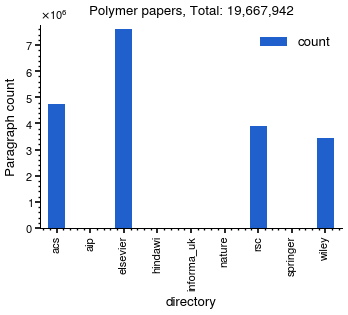

,directory,count
0,acs,4726853
1,aip,4
2,elsevier,7628515
3,hindawi,74
4,informa_uk,24
5,nature,11
6,rsc,3884198
7,springer,63
8,wiley,3428200


In [6]:
df = execute("""
        SELECT directory, count(*) FROM paper_texts pt
        -- only the polymer papers
        JOIN filtered_papers fp ON fp.doi = pt.doi 
        GROUP BY directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Paragraph count', title=f"Polymer papers, Total: {total:,}")
plt.savefig('notebooks/poly_paragraphs_per_directory.png', dpi=600)
plt.show()
df

### Filtering

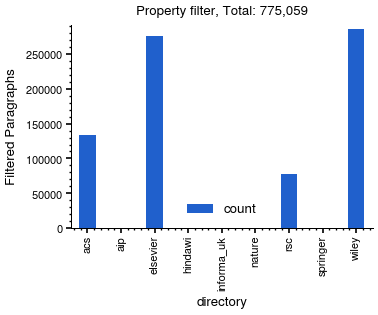

,directory,count
0,acs,134396
1,aip,4
2,elsevier,276356
3,hindawi,5
4,informa_uk,33
5,nature,16
6,rsc,77498
7,springer,94
8,wiley,286657


In [8]:
df = execute("""
    -- property specific ner filters
    SELECT pt.directory, count(*) FROM filtered_paragraphs fp
    -- get directory names
    JOIN paper_texts pt ON fp.para_id = pt.id
    WHERE fp.filter_name LIKE 'property_%'
    GROUP BY pt.directory;
""")
total = df['count'].sum()

fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Filtered Paragraphs',
       title = f'Property filter, Total: {total:,}')
plt.savefig('notebooks/property_filtered_para_per_directory.png', dpi=600)
plt.show()
df

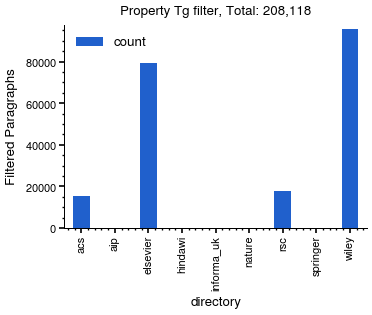

,directory,count
0,acs,15156
1,aip,2
2,elsevier,79207
3,hindawi,2
4,informa_uk,15
5,nature,10
6,rsc,17842
7,springer,53
8,wiley,95831


In [9]:
df = execute("""
    -- property specific ner filters
    SELECT pt.directory, count(*) FROM filtered_paragraphs fp
    -- get directory names
    JOIN paper_texts pt ON fp.para_id = pt.id
    WHERE fp.filter_name = 'property_tg'
    GROUP BY pt.directory;
""")
total = df['count'].sum()

fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Filtered Paragraphs',
       title = f'Property Tg filter, Total: {total:,}')
plt.savefig('notebooks/tg_filtered_para_per_directory.png', dpi=600)
plt.show()
df

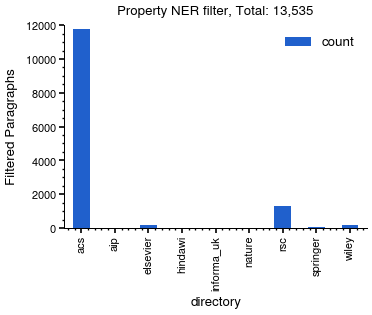

,directory,count
0,acs,11793
1,aip,2
2,elsevier,167
3,hindawi,2
4,informa_uk,19
5,nature,15
6,rsc,1275
7,springer,73
8,wiley,189


In [10]:
df = execute("""
    -- property specific ner filters
    SELECT pt.directory, count(*) FROM filtered_paragraphs fp
    -- get directory names
    JOIN paper_texts pt ON fp.para_id = pt.id
    WHERE fp.filter_name LIKE 'ner_%'
    AND fp.filter_name != 'ner_filter'
    GROUP BY pt.directory;
""")
total = df['count'].sum()

fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Filtered Paragraphs',
       title = f'Property NER filter, Total: {total:,}')
plt.savefig('notebooks/property_ner_filtered_para_per_directory.png', dpi=600)
plt.show()
df

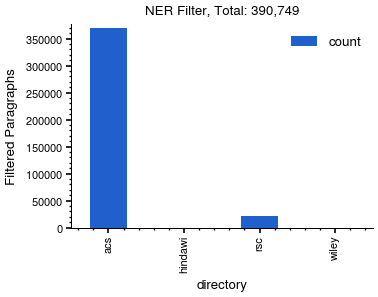

,directory,count
0,acs,369040
1,hindawi,3
2,rsc,21704
3,wiley,2


In [12]:
df = execute("""
    -- general ner filter
    SELECT pt.directory, count(*) FROM filtered_paragraphs fp
    -- get directory names
    JOIN paper_texts pt ON fp.para_id = pt.id
    WHERE fp.filter_name = 'ner_filter'
    GROUP BY pt.directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Filtered Paragraphs', title = f'NER Filter, Total: {total:,}')
plt.savefig('notebooks/ner_filtered_para_per_directory.png', dpi=600)
plt.show()
df

### Extracted Data

In [13]:
# Materials extracted.
execute("select count(*) from extracted_materials")

,count
0,418708


In [14]:
# Properties extracted.
execute("select count(*) from extracted_properties")

,count
0,872951


In [15]:
def extract_properties(property : str):
    df = execute("""
        SELECT pt.doi, em.entity_name AS material, ep.numeric_value, ep.unit
        FROM extracted_properties ep
        -- get material name and class
        JOIN extracted_materials em ON em.id = ep.material_id
        -- get doi
        JOIN paper_texts pt ON pt.id = em.para_id
        -- filter with property coreferents
        WHERE ep.entity_name IN (
            SELECT UNNEST(pm.other_names) FROM property_metadata pm
            WHERE pm.name = :prop_name
        )
        -- value should be within range
        AND ep.numeric_value >= (
            SELECT lower_limit FROM property_metadata
            WHERE name = :prop_name
        )
        AND ep.numeric_value <= (
            SELECT upper_limit FROM property_metadata
            WHERE name = :prop_name
        )
        -- select only polymers
        AND em.material_class LIKE 'POLYMER%';
    """, prop_name=property)
    return df

In [16]:
def unit_counts(df):
    return df.groupby('unit').nunique().numeric_value.sort_values(ascending=False)

In [17]:
def plot_histogram(df, name):
    # Most common unit
    unit = df.groupby('unit').nunique().numeric_value.sort_values(ascending=False).index[0]
    avg = df.numeric_value.mean()
    stdev = df.numeric_value.std()

    fig, ax = plt.subplots()
    df.hist('numeric_value', bins=20, label=f'Total: {df.shape[0]:,}', ax=ax)
    ax.legend()
    ax.set(xlabel=f'{name} ({unit})', ylabel='count',
           title=f'Extracted {name} data\nMean = {avg:0.2f}, St. dev. = {stdev:0.2f}')
    plt.savefig(f'notebooks/hist.{name.replace("/", "_")}.png', dpi=300)
    plt.show()

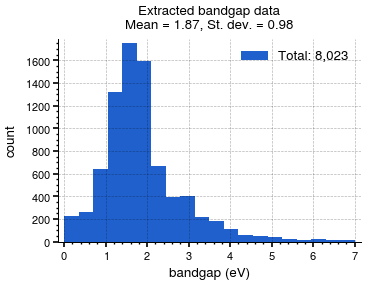

,doi,material,numeric_value,unit
0,10.1021/acsami.8b18665,TRZ-CF,2.97,eV
1,10.1021/acsami.8b18665,TRZ-CF,3.05,eV
2,10.1021/cm803307f,PbSe,0.31,eV
3,10.1021/cm803307f,PbSe,0.67,eV
4,10.1021/acs.jpcc.6b05216,PDTS-DTffBT,1.60,eV
...,...,...,...,...
8018,10.1021/ma060683o,PSAF,3.00,eV
8019,10.1021/acsenergylett.8b01808,SeTIC,1.57,eV
8020,10.1021/acsenergylett.8b01808,SeTIC,1.44,eV
8021,10.1021/acsenergylett.8b01808,SeTIC,1.58,eV


In [18]:
df = extract_properties('bandgap')
plot_histogram(df, 'bandgap')
df

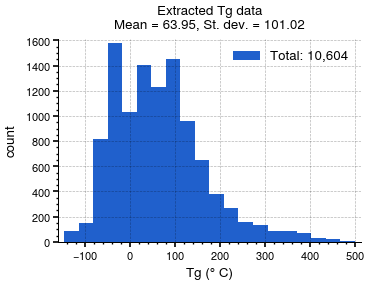

,doi,material,numeric_value,unit
0,10.1021/am2006367,PLLA,58.00,° C
1,10.1021/am2006367,PRA,-71.00,° C
2,10.1021/am2006367,PLLA,54.50,° C
3,10.1021/am900875g,PEG,-2.90,° C
4,10.1021/am900875g,PEG,-24.00,° C
...,...,...,...,...
10599,10.1021/acs.molpharmaceut.9b00186,KTZ,21.85,+ / ° C
10600,10.1021/ma951549z,P3HB,-50.00,° C
10601,10.1021/acs.macromol.5b02788,T,198.50,° C
10602,10.1021/acs.macromol.5b02788,F-PEKs,198.50,° C


In [19]:
df = extract_properties('glass transition temperature')
plot_histogram(df, 'Tg')
df

In [11]:
# Make histograms for all properties.
props = execute("select * from property_metadata")
# for prop in props.name:
#     df = extract_properties(prop)
#     if df is not None:
#         plot_histogram(df, prop)

In [7]:
postgres.disconnect()